{'mean': Overall rank                    78.500000
Score                            5.407096
GDP per capita                   0.905147
Social support                   1.208814
Healthy life expectancy          0.725244
Freedom to make life choices     0.392571
Generosity                       0.184846
Perceptions of corruption        0.110603
dtype: float64, 'median': Overall rank                    78.5000
Score                            5.3795
GDP per capita                   0.9600
Social support                   1.2715
Healthy life expectancy          0.7890
Freedom to make life choices     0.4170
Generosity                       0.1775
Perceptions of corruption        0.0855
dtype: float64, 'mode': Overall rank                    1.000
Score                           5.208
GDP per capita                  0.960
Social support                  1.465
Healthy life expectancy         0.815
Freedom to make life choices    0.498
Generosity                      0.153
Perceptions of corr

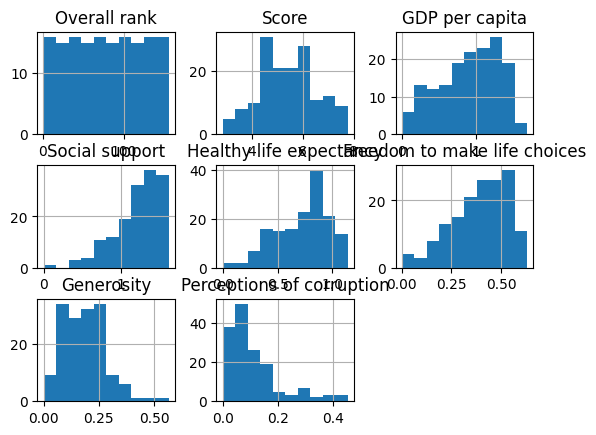

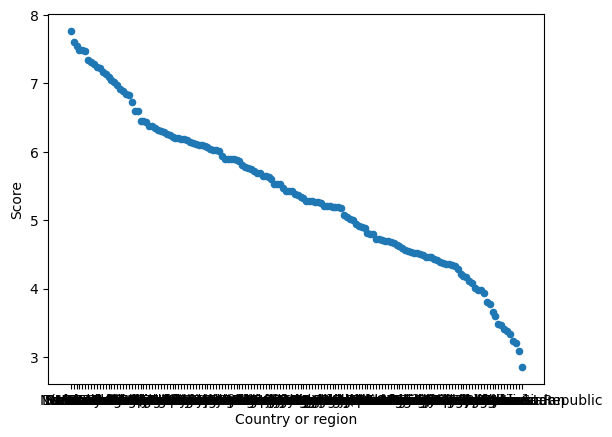

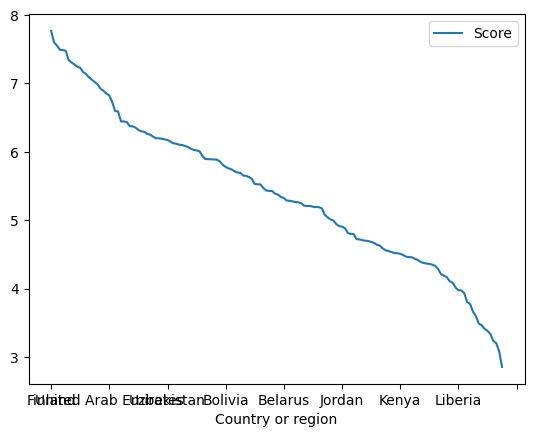

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Input Prompt: What is the value of  GDP per capita of Finland provided in the data?


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Response:   The value of GDP per capita of Finland according to the given data is $1.340.
Input Prompt: exit
Exiting


SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#from llama_api import Llama
file_path='/content/2019.csv'
# Read and parse CSV
def read_csv(file_path):
    return pd.read_csv(file_path)

# Perform statistical analysis
def basic_statistics(df):
    # Select only numeric columns for calculations
    numeric_df = df.select_dtypes(include=['number'])
    stats = {
        'mean': numeric_df.mean(),
        'median': numeric_df.median(),
        'mode': numeric_df.mode().iloc[0],
        'std_dev': numeric_df.std(),
        'correlation': numeric_df.corr()
    }
    return stats

# Generate plots
def generate_plots(df, plot_type, x_column=None, y_column=None):
    if plot_type == 'histogram':
        df.hist()
    elif plot_type == 'scatter' and x_column and y_column:
        if x_column in df.columns and y_column in df.columns:
            df.plot.scatter(x=x_column, y=y_column)
        else:
            print(f"Error: Columns '{x_column}' and/or '{y_column}' not found in DataFrame.")
    elif plot_type == 'line' and x_column and y_column:
        df.plot.line(x=x_column, y=y_column)
    plt.show()

# Answer questions with Llama 2
def answer_question():

  from langchain.document_loaders.csv_loader import CSVLoader
  from langchain.text_splitter import RecursiveCharacterTextSplitter
  from langchain.embeddings import HuggingFaceEmbeddings
  from langchain.vectorstores import FAISS
  from langchain.llms import CTransformers
  from langchain.memory import ConversationBufferMemory
  from langchain.chains import ConversationalRetrievalChain
  import sys
  from huggingface_hub import hf_hub_download
  import os


  DB_FAISS_PATH = "/content/sample_data/db_faiss"
  loader = CSVLoader(file_path="/content/2019.csv", encoding="utf-8", csv_args={'delimiter': ','})
  data = loader.load()
#print(data)

# Split the text into Chunks
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)
  text_chunks = text_splitter.split_documents(data)

#print(len(text_chunks))

# Download Sentence Transformers Embedding From Hugging Face
  embeddings = HuggingFaceEmbeddings(model_name = 'sentence-transformers/all-MiniLM-L6-v2')

# COnverting the text Chunks into embeddings and saving the embeddings into FAISS Knowledge Base
  docsearch = FAISS.from_documents(text_chunks, embeddings)

  docsearch.save_local(DB_FAISS_PATH)


#query = "What is the value of GDP per capita of Finland provided in the data?"

#docs = docsearch.similarity_search(query, k=3)

#print("Result", docs)

# Download the model if it doesn't exist
  model_path = "models/llama-2-7b-chat.ggmlv3.q4_0.bin"
  if not os.path.exists(model_path):
      hf_hub_download(repo_id="TheBloke/Llama-2-7B-Chat-GGML", filename="llama-2-7b-chat.ggmlv3.q4_0.bin", local_dir="models")

# Provide your Hugging Face token if the model requires authentication
# os.environ["HUGGINGFACEHUB_API_TOKEN"] = "your_huggingface_token"

  llm = CTransformers(model=model_path,
                    model_type="llama",
                    max_new_tokens=512,
                    temperature=0.1)

  qa = ConversationalRetrievalChain.from_llm(llm, retriever=docsearch.as_retriever())

  while True:
      chat_history = []
    #query = "What is the value of  GDP per capita of Finland provided in the data?"
      query = input(f"Input Prompt: ")
      if query == 'exit':
        print('Exiting')
        sys.exit()
      if query == '':
        continue
      result = qa({"question":query, "chat_history":chat_history})
      print("Response: ", result['answer'])


# Example usage
if __name__ == "__main__":
    file_path = '/content/2019.csv'
    df = read_csv(file_path)

    stats = basic_statistics(df)
    print(stats)

    generate_plots(df, 'histogram')

    # Replace 'column1' and 'column2' with actual column names from your dataset
    generate_plots(df, 'scatter', x_column='Country or region', y_column='Score')
    generate_plots(df, 'line', x_column='Country or region', y_column='Score')
    answer_question()
